<a href="https://colab.research.google.com/github/olliwho/outlier_detection/blob/main/IaVU_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install alibi_detect

### Imports


In [ ]:
from alibi_detect.models import PixelCNN
from alibi_detect.models.losses import elbo
from alibi_detect.models.autoencoder import eucl_cosim_features
from alibi_detect.od import OutlierVAE, OutlierVAEGMM, LLR
from alibi_detect.utils.saving import load_detector
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils import visualize as viz
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.utils.prediction import predict_batch

import tensorflow as tf
from tensorflow.python.keras.engine.input_layer import InputLayer
from tensorflow.python.keras.layers import Conv2D, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.metrics import MeanSquaredError, AUC, Precision, Recall

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from tqdm import tqdm
import random

from google.colab import drive

Mount Drive and set paths


In [ ]:
if 'google.colab' in str(get_ipython()):
    drive.mount('/content/drive')
    path = "/content/drive/MyDrive/detectors"
    plots_path = "/content/drive/MyDrive/plots"
    print('Running on CoLab')
else:
    print('Not running on CoLab')
    path = "./detectors"
    plots_path = "./plots"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load

In [ ]:
load = True
fetch = False

### CIFAR10 dataset

In [ ]:
dataset = 'cifar10'
train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

X = X_train[:500]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X.shape)

input_shape=X_train.shape[1:]

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)
(500, 32, 32, 3)


### (Fashion-)MNIST dataset

In [ ]:
def load_data(dataset: str) -> tuple:
    if dataset == 'mnist':
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    elif dataset == 'fashion_mnist':
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    else:
        raise NotImplementedError
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255
    y_train = y_train.astype('int64').reshape(-1,)
    y_test = y_test.astype('int64').reshape(-1,)
    if len(X_train.shape) == 3:
        shape = (-1,) + X_train.shape[1:] + (1,)
        X_train = X_train.reshape(shape)
        X_test = X_test.reshape(shape)
    return (X_train, y_train), (X_test, y_test)

(X_train_in, y_train_in), (X_test_in, y_test_in) = load_data('fashion_mnist')

X_train_in = np.pad(X_train_in,((0,0),(2,2),(2,2),(0,0)),constant_values=(0,))
X_test_in = np.pad(X_test_in,((0,0),(2,2),(2,2),(0,0)),constant_values=(0,))


X_test_ood, y_test_ood = load_data('mnist')[1]

X_test_ood = np.pad(X_test_ood, ((0,0),(2,2),(2,2),(0,0)), constant_values=(0,))


input_shape_in = X_train_in.shape[1:]

print(X_train_in.shape, X_test_in.shape, X_test_ood.shape)
print(y_train_in.shape, y_test_in.shape, y_test_ood.shape)

(60000, 32, 32, 1) (10000, 32, 32, 1) (10000, 32, 32, 1)
(60000,) (10000,) (10000,)


### VAE

In [ ]:
if fetch:
    detector_type = 'outlier'
    detector_name = 'OutlierVAE'
    dataset = 'cifar10'
    od_v = fetch_detector(path, detector_type, dataset, detector_name)
elif load:
    od_v = load_detector(os.path.join(path, 'OutlierVAE_Cifar10'))

In [ ]:
if load:
    od_v1 = load_detector(os.path.join(path, 'OutlierVAE_FMNIST'))

No threshold level set. Need to infer threshold using `infer_threshold`.


### VAEGMM

In [ ]:
if load:
    od_vg = load_detector(os.path.join(path, 'OutlierVAEGMM_Cifar10'))

In [ ]:
if load:
    od_vg1 = load_detector(os.path.join(path, 'OutlierVAEGMM_FMNIST'))

No threshold level set. Need to infer threshold using `infer_threshold`.


### LR

In [ ]:
model = PixelCNN(
    image_shape=input_shape,
    num_resnet=5,
    num_hierarchies=2,
    num_filters=32,
    num_logistic_mix=1,
    receptive_field_dims=(3, 3),
    dropout_p=.3,
    l2_weight=0.
)

if load:
    kwargs = {'dist_s': model, 'dist_b': model.copy(), 'input_shape': input_shape}
    od_lr = load_detector(os.path.join(path, "LR_Cifar10"), **kwargs)

No threshold level set. Need to infer threshold using `infer_threshold`.


In [ ]:
model = PixelCNN(
    image_shape=input_shape_in,
    num_resnet=5,
    num_hierarchies=2,
    num_filters=32,
    num_logistic_mix=1,
    receptive_field_dims=(3, 3),
    dropout_p=.3,
    l2_weight=0.
)

if fetch:
    detector_type = 'outlier'
    dataset = 'fashion_mnist'
    detector_name = 'LLR'
    od_lr1 = fetch_detector(path, detector_type, dataset, detector_name)
elif load:
    kwargs = {'dist_s': model, 'dist_b': model.copy(), 'input_shape': input_shape}
    od_lr1 = load_detector(os.path.join(path, "LR_FMNIST"), **kwargs)

No threshold level set. Need to infer threshold using `infer_threshold`.


### Infer thresholds

In [ ]:
# assume 1% of the training data are outliers
od_v.infer_threshold(X, threshold_perc=99) 
od_vg.infer_threshold(X, threshold_perc=99) 
od_lr.infer_threshold(X, threshold_perc=99)  


shape_in, shape_ood = X_test_in.shape[0], X_test_ood.shape[0]

n, frac_outlier = 500, .5
perc_outlier = 100 * frac_outlier
n_in, n_ood = int(n * (1 - frac_outlier)), int(n * frac_outlier)
idx_in = np.random.choice(shape_in, size=n_in, replace=False)
idx_ood = np.random.choice(shape_ood, size=n_ood, replace=False)
X_threshold = np.concatenate([X_test_in[idx_in], X_test_ood[idx_ood]])

od_v1.infer_threshold(X_threshold, threshold_perc=perc_outlier, batch_size=32)
od_vg1.infer_threshold(X_threshold, threshold_perc=perc_outlier, batch_size=32)
od_lr1.infer_threshold(X_threshold, threshold_perc=perc_outlier, batch_size=32)

# Part 1

Predicting
This can take some time, le likleyhood ratio detector needs longer

In [ ]:
od_v_preds = od_v.predict(X)
od_vg_preds = od_vg.predict(X)
od_lr_preds = od_lr.predict(X)

<Figure size 432x288 with 0 Axes>

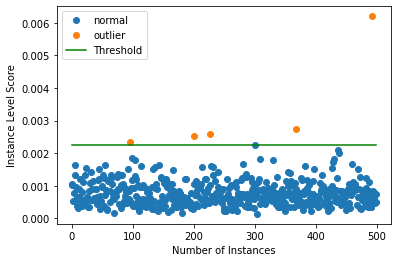

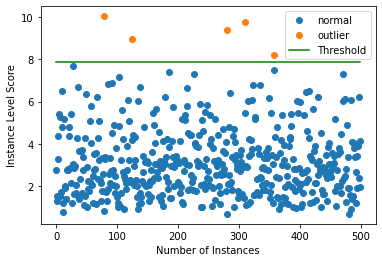

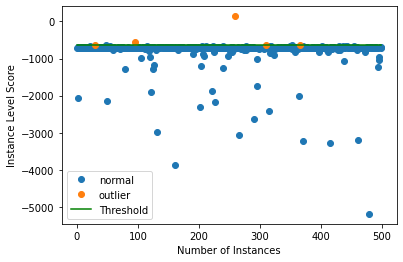

In [ ]:
from typing import Dict, Union
def plot_instance_score(preds: Dict,
                        target: np.ndarray,
                        labels: np.ndarray,
                        threshold: float,
                        ylim: tuple = (None, None)) -> None:

    scores = preds['data']['instance_score']
    df = pd.DataFrame(dict(idx=np.arange(len(scores)), score=scores, label=target))
    groups = df.groupby('label')
    fig, ax = plt.subplots()
    for name, group in groups:
        ax.plot(group.idx, group.score, marker='o', linestyle='', ms=6, label=labels[name])
    plt.plot(np.arange(len(scores)), np.ones(len(scores)) * threshold, color='g', label='Threshold')
    plt.ylim(ylim)
    plt.xlabel('Number of Instances')
    plt.ylabel('Instance Level Score')
    ax.legend()

# target = np.zeros(X.shape[0],).astype(int)  # all normal CIFAR10 training instances
# target = y_test.reshape([500])
# target = outlier_batch_target.reshape(outlier_batch_target.shape[0])
plt.figure()
labels = ['normal', 'outlier']

#VAE
target = od_v_preds['data']['is_outlier']
plot_instance_score(od_v_preds, target, labels, od_v.threshold)
plt.savefig(os.path.join(plots_path, "instance_score_vae.png"))

#VAEGMM
target = od_vg_preds['data']['is_outlier']
plot_instance_score(od_vg_preds, target, labels, od_vg.threshold)
plt.savefig(os.path.join(plots_path, "instance_score_vaegmm.png"))

#LR
target = od_lr_preds['data']['is_outlier']
plot_instance_score(od_lr_preds, target, labels, od_lr.threshold)
plt.savefig(os.path.join(plots_path, "instance_score_lr.png"))

In [ ]:
n_mask_sizes = 10
n_masks = 20
n_imgs = 50

mask_sizes = [(2*n,2*n) for n in range(1,n_mask_sizes+1)]
print(mask_sizes)
img_ids = np.arange(n_imgs)
X_orig = X[img_ids].reshape(img_ids.shape[0], 32, 32, 3)
print(X_orig.shape)

[(2, 2), (4, 4), (6, 6), (8, 8), (10, 10), (12, 12), (14, 14), (16, 16), (18, 18), (20, 20)]
(50, 32, 32, 3)


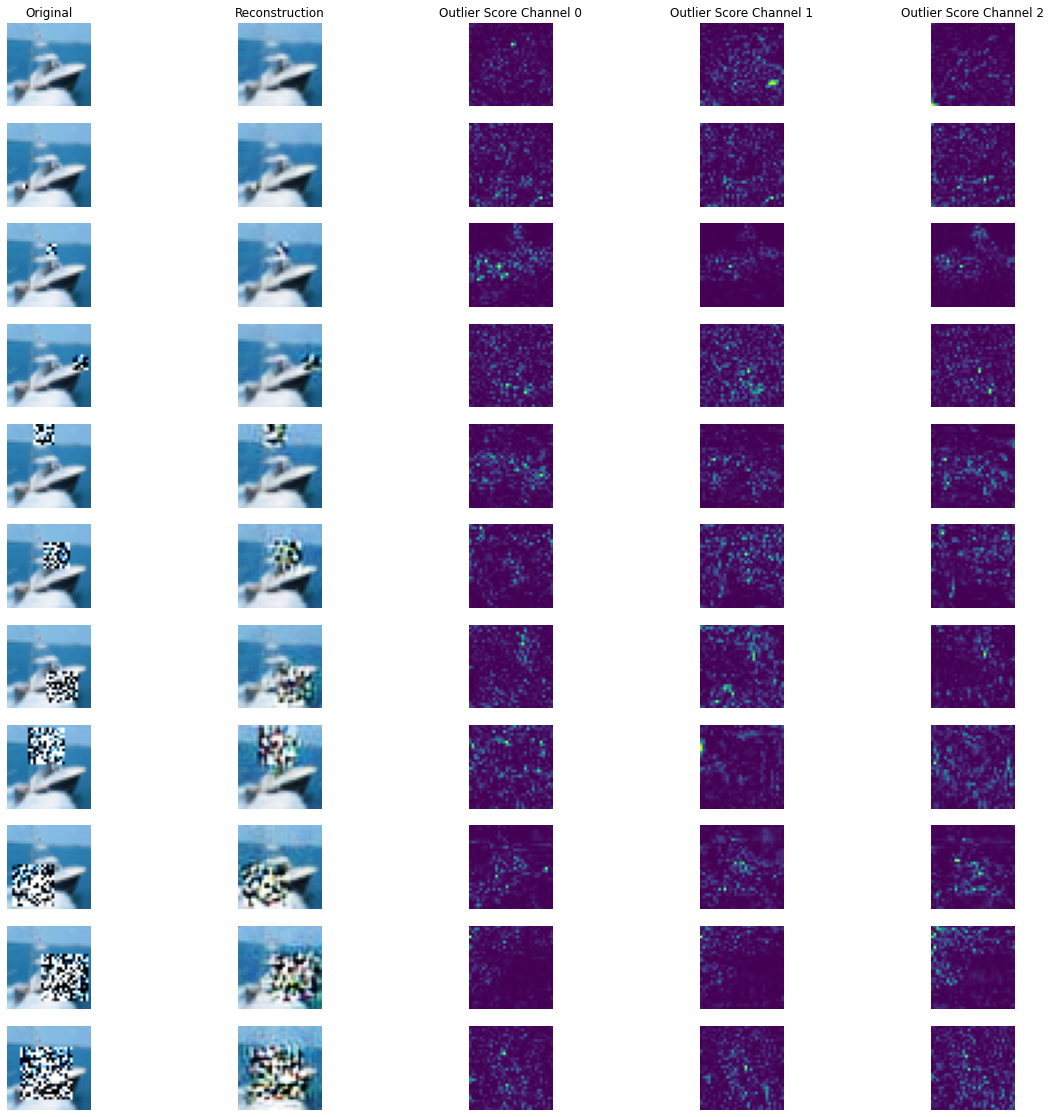

In [ ]:
all_X_mask = []
X_i = X_orig[8].reshape(1, 32, 32, 3)
all_X_mask.append(X_i)
# apply masks
for j, mask_size in enumerate(mask_sizes):
    # create masked instances
    X_mask, mask = apply_mask(X_i,
                              mask_size=mask_size,
                              n_masks=1,  # just 1 for visualization purposes
                              channels=[0,1,2],
                              mask_type='normal',
                              noise_distr=(0,1),
                              clip_rng=(0,1))
    all_X_mask.append(X_mask)
all_X_mask = np.concatenate(all_X_mask, axis=0)
all_X_recon = od_v.vae(all_X_mask).numpy()
od_preds = od_v.predict(all_X_mask)

viz.plot_feature_outlier_image(od_v_preds,
                           all_X_mask,
                           X_recon=all_X_recon,
                           max_instances=all_X_mask.shape[0],
                           n_channels=3)

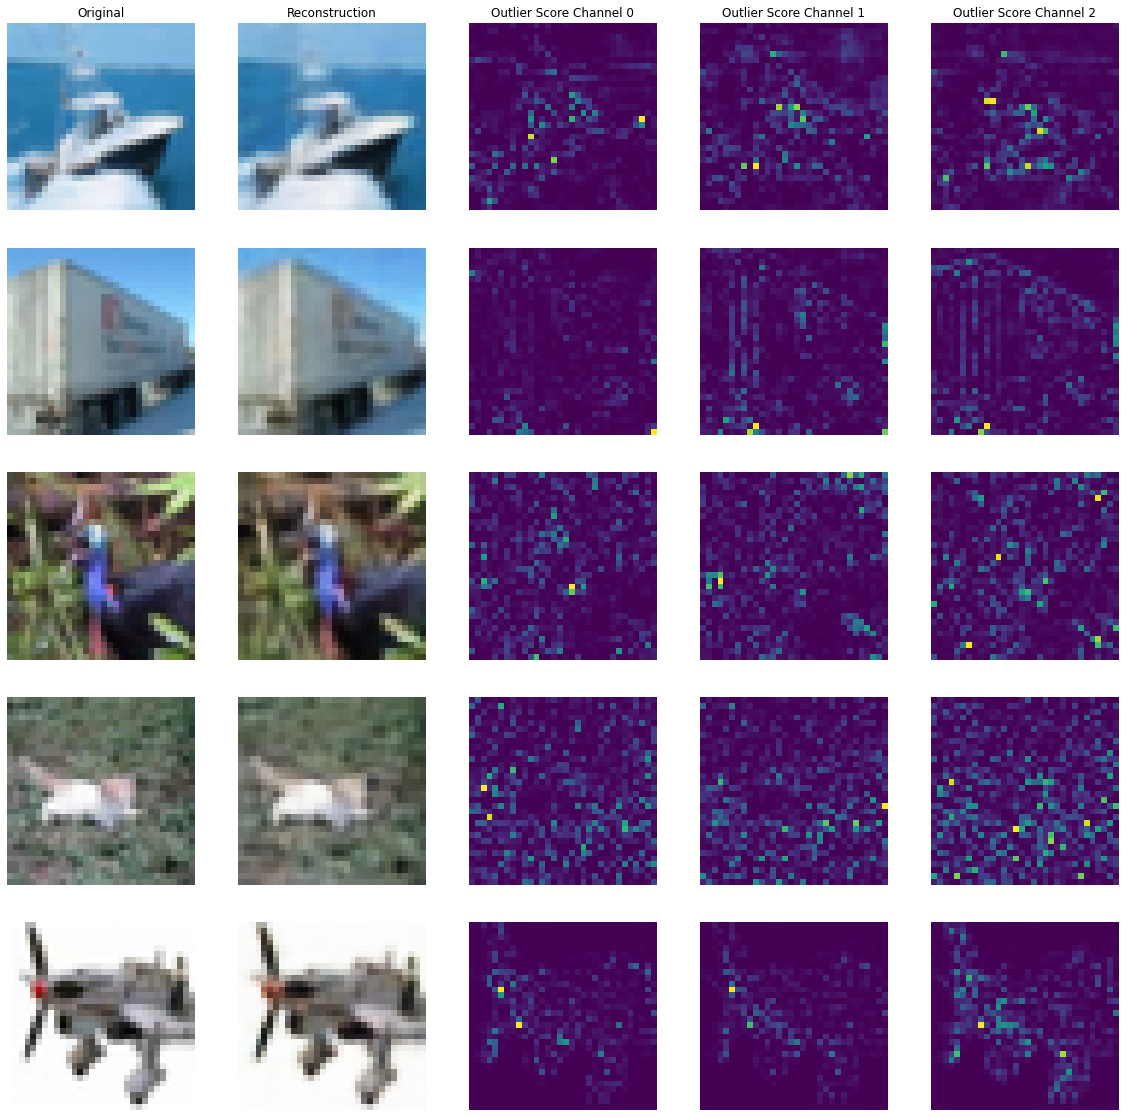

In [ ]:
X_recon = od_v.vae(X).numpy()
viz.plot_feature_outlier_image(od_v_preds,
                           X,
                           X_recon=X_recon,
                           instance_ids=[8, 15, 24, 39, 49])

The prediction in this step takes long

In [ ]:
all_img_scores_v = []
all_img_scores_vg = []
all_img_scores_lr = []
for i in tqdm(range(X_orig.shape[0])):
    img_scores_v = np.zeros((len(mask_sizes),))
    img_scores_vg = np.zeros((len(mask_sizes),))
    img_scores_lr = np.zeros((len(mask_sizes),))
    for j, mask_size in enumerate(mask_sizes):
        # create masked instances
        X_mask, mask = apply_mask(X_orig[i].reshape(1, 32, 32, 3),
                                  mask_size=mask_size,
                                  n_masks=n_masks,
                                  channels=[0,1,2],
                                  mask_type='normal',
                                  noise_distr=(0,1),
                                  clip_rng=(0,1))
        # predict outliers
        od_v_preds_mask = od_v.predict(X_mask)
        od_vg_preds_mask = od_vg.predict(X_mask)
        od_lr_preds_mask = od_lr.predict(X_mask)

        score_v = od_v_preds_mask['data']['instance_score']
        score_vg = od_vg_preds_mask['data']['instance_score']
        score_lr = od_lr_preds_mask['data']['instance_score']

        # store average score over `n_masks` for a given mask size
        img_scores_v[j] = np.mean(score_v)
        img_scores_vg[j] = np.mean(score_vg)
        img_scores_lr[j] = np.mean(score_lr)

    all_img_scores_v.append(img_scores_v)
    all_img_scores_vg.append(img_scores_vg)
    all_img_scores_lr.append(img_scores_lr)

100%|██████████| 50/50 [12:43<00:00, 15.26s/it]


No handles with labels found to put in legend.


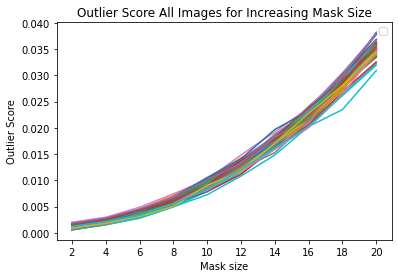

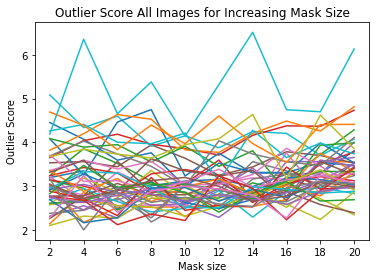

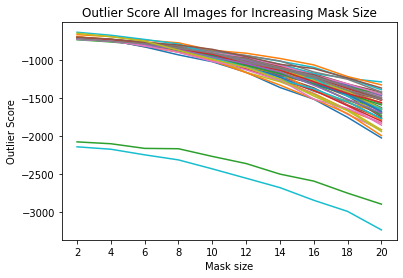

In [ ]:
x_plt = [mask[0] for mask in mask_sizes]
for ais in all_img_scores_v:
    plt.plot(x_plt, ais)
    plt.xticks(x_plt)
plt.title('Outlier Score All Images for Increasing Mask Size')
plt.xlabel('Mask size')
plt.ylabel('Outlier Score')
plt.savefig(os.path.join(plots_path, "os_inc_mask_vae"))
plt.legend()
plt.show()

for ais in all_img_scores_vg:
    plt.plot(x_plt, ais)
    plt.xticks(x_plt)
plt.title('Outlier Score All Images for Increasing Mask Size')
plt.xlabel('Mask size')
plt.ylabel('Outlier Score')
plt.savefig(os.path.join(plots_path, "os_inc_mask_vaegmm"))
plt.show()

for ais in all_img_scores_lr:
    plt.plot(x_plt, ais)
    plt.xticks(x_plt)
plt.title('Outlier Score All Images for Increasing Mask Size')
plt.xlabel('Mask size')
plt.ylabel('Outlier Score')
plt.savefig(os.path.join(plots_path, "os_inc_mask_lr"))
plt.show()

# Part 2

Predict

In [ ]:
X_test = np.concatenate([X_test_in, X_test_ood])
y_test = np.concatenate([np.zeros(X_test_in.shape[0]), np.ones(X_test_ood.shape[0])])
print(X_test.shape, y_test.shape)


od_v1_preds = od_v1.predict(X_test, batch_size=32)
od_vg1_preds = od_vg1.predict(X_test, batch_size=32)
od_lr1_preds = od_lr1.predict(X_test, batch_size=32)

(20000, 32, 32, 1) (20000,)


F1 score: 0.723 -- Accuracy: 0.723 -- Precision: 0.724 -- Recall: 0.721


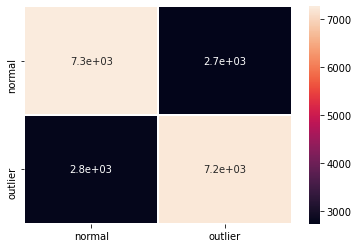

F1 score: 0.757 -- Accuracy: 0.756 -- Precision: 0.755 -- Recall: 0.758


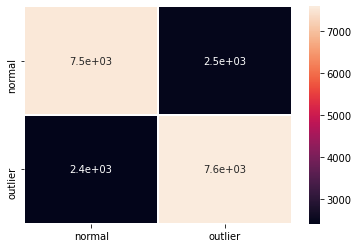

F1 score: 0.864 -- Accuracy: 0.864 -- Precision: 0.866 -- Recall: 0.863


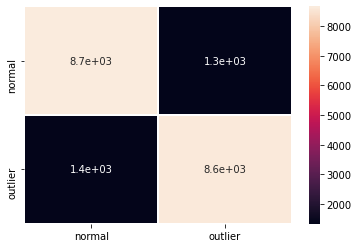

In [ ]:
def metrics(od_preds, name):
    y_pred = od_preds['data']['is_outlier']
    labels = ['normal', 'outlier']
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    print('F1 score: {:.3f} -- Accuracy: {:.3f} -- Precision: {:.3f} '
        '-- Recall: {:.3f}'.format(f1, acc, prec, rec))
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
    plt.savefig(os.path.join(plots_path, "metrics_" + name))
    plt.show()
    # plot_instance_score(od_preds, y_test, labels, od.threshold, ylim=(None, None))

metrics(od_v1_preds, "vae")
metrics(od_vg1_preds, "vaegmm")
metrics(od_lr1_preds, "lr")

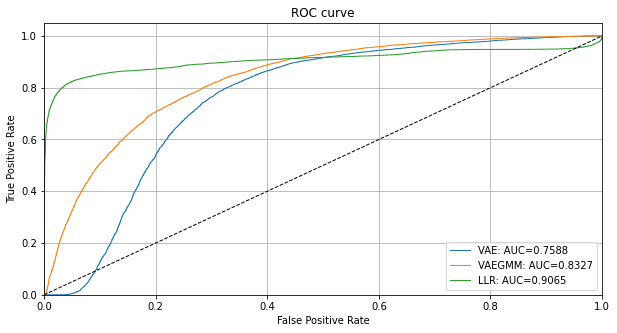

In [ ]:
roc_data = {
    'VAE': {'scores': od_v1_preds['data']['instance_score'], 'labels': y_test},
    'VAEGMM': {'scores': od_vg1_preds['data']['instance_score'], 'labels': y_test},
    'LLR': {'scores': od_lr1_preds['data']['instance_score'], 'labels': y_test}
}
viz.plot_roc(roc_data)